# Heating Rates with PyARTS

In [1]:
%matplotlib inline


# Set path to line catalogue
import os
import warnings
warnings.filterwarnings('ignore')

if os.path.isdir('/share/share/ESCI345'):
    os.environ["ARTS_DATA_PATH"] = "/share/share/ESCI345/"
    os.environ["ARTS_XML_ATMO"] = "/share/share/ESCI345/atmospheres/"
else:
    os.environ["ARTS_DATA_PATH"] = "/Users/wgblumbe/Code/rttools/arts_catalogs/arts-cat-data-snapshot-arts-2.5.8/"
    os.environ["ARTS_XML_ATMO"] = "/Users/wgblumbe/Code/rttools/ESCI345/atmospheres/"
    
import matplotlib.pyplot as plt
import numpy as np
import typhon as ty
from pyarts import xml
from heating_rates_module import (calc_spectral_irradiance, calc_irradiance,
                                  integrate_spectral_irradiance)
import pint
import proplot as pplt

ureg = pint.UnitRegistry()
#ty.plots.styles.use("seaborn-talk")
pplt.use_style('seaborn-talk')
pplt.rc["legend.facecolor"] = "white"


The heating rate denotes the change of atmospheric temperature with time due
to gain or loss of energy. Here, we consider only the gain or loss due to
radiation.
The heating rate including only radiation is  

$$\frac{\partial T\left(z\right)}{\partial t}=-\frac{1}{\rho\left( z \right) c_p }\frac{\partial}{\partial z}F_{net}\left( z \right)$$

with $\rho\left( z \right)$ the density of dry air (To keep it simple, we assume dry air. 
In reality the air is not dry. Nonetheless, the differences are small.), $c_p = 1.0035\, \text{J}\, \text{kg}^{-1} \text{K}^{-1}$ the specific heat 
capacity of dry air and $F_{net}$ the net radiation flux. 
The net radiation flux is  

$$F_{net}=F_{up}-F_{down}$$

with $F_{up}$ and $F_{down}$ the up- and downward radiation flux (irradiance), respectively. 
The density of dry air is  

$$\rho  =\frac{p}{R_s\,T}$$

with pressure $p$, temperature  $T$ and the specific gas constant 
$R_s = 287.058\, \text{J}\,\text{kg}^{-1} \text{K}^{-1}$.

Before we start, we need to load an atmosphere.

In [2]:
# Read input atmosphere
atmfield = xml.load("input/midlatitude-summer.xml")

### 1)
Run the next cell. This will calculate the upward and downward longwave radiation fluxes.  
Here, we will consider only the longwave flux. Calculate the net flux and plot upward,  
downward and net flux together in one figure against altitude. Explain the plot.  

In [3]:
# Calculate the radiation irradiance (flux)

z, p, T, flux_downward, flux_upward = calc_irradiance(atmfield)

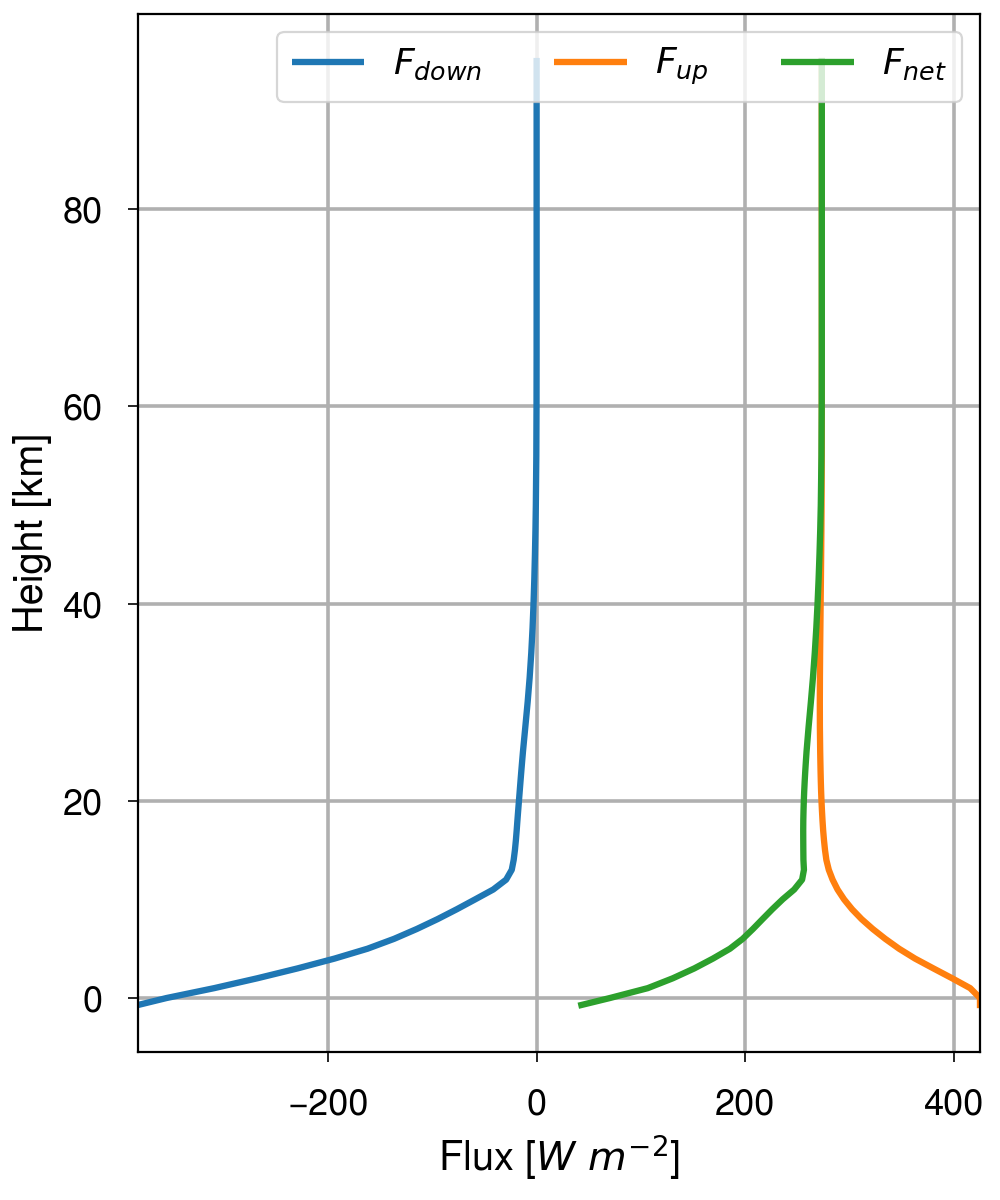

In [4]:
#  Calculate net flux and plot up-, down- and net flux
net_flux = flux_upward - flux_downward

fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(5,6))
axs.plot(-flux_downward, z/1000., label="$F_{down}$")
axs.plot(flux_upward, z/1000., label="$F_{up}$")
axs.plot(net_flux, z/1000., label="$F_{net}$")
axs.legend()
axs.format(grid=True, ylabel="Height [km]", xlabel="Flux [$W\ m^{-2}$]")
pplt.show()

### 2)
Implement the function `calc_heatingrates(...)`. Use the function to calculate  
the heating rate. Plot the heating rate against altitude and explain the plot. How would  
a heating rate in thermal equilibrium assuming only longwave radiation look like?  
Why is the heating rate so much higher in the stratosphere than in the troposphere?

In [5]:
# Implement heating rate function

def calc_heatingrates(z, p, T, Fnet):
    """Calculate the heating rate.

    Parameters:
        z (ndarray): Altitude [m].
        p (ndarray): Pressure [Pa].
        T (ndarray): Temperature [K].
        Fnet (ndarray): Net flux [W m^-2].

    Returns:
        ndarray, ndarray:
        Heating rate [K/d], Altitude [m].
    """

    Rs = 287.058 # J/kg K
    density = (p/(Rs * T))[np.newaxis,...] # Should use the virtual temperature correction here...
    Cp = 1003.5 # J/kg/K
    #print(density)
    grad_flux = np.gradient(Fnet, z, axis=0)
    #print(grad_flux.shape, density.shape)
    if grad_flux.ndim != 1:
        heating_rate = grad_flux * (1./(density * Cp)).T
    else:
        heating_rate = grad_flux * (1./(density * Cp).squeeze()).T

    
    return heating_rate, z

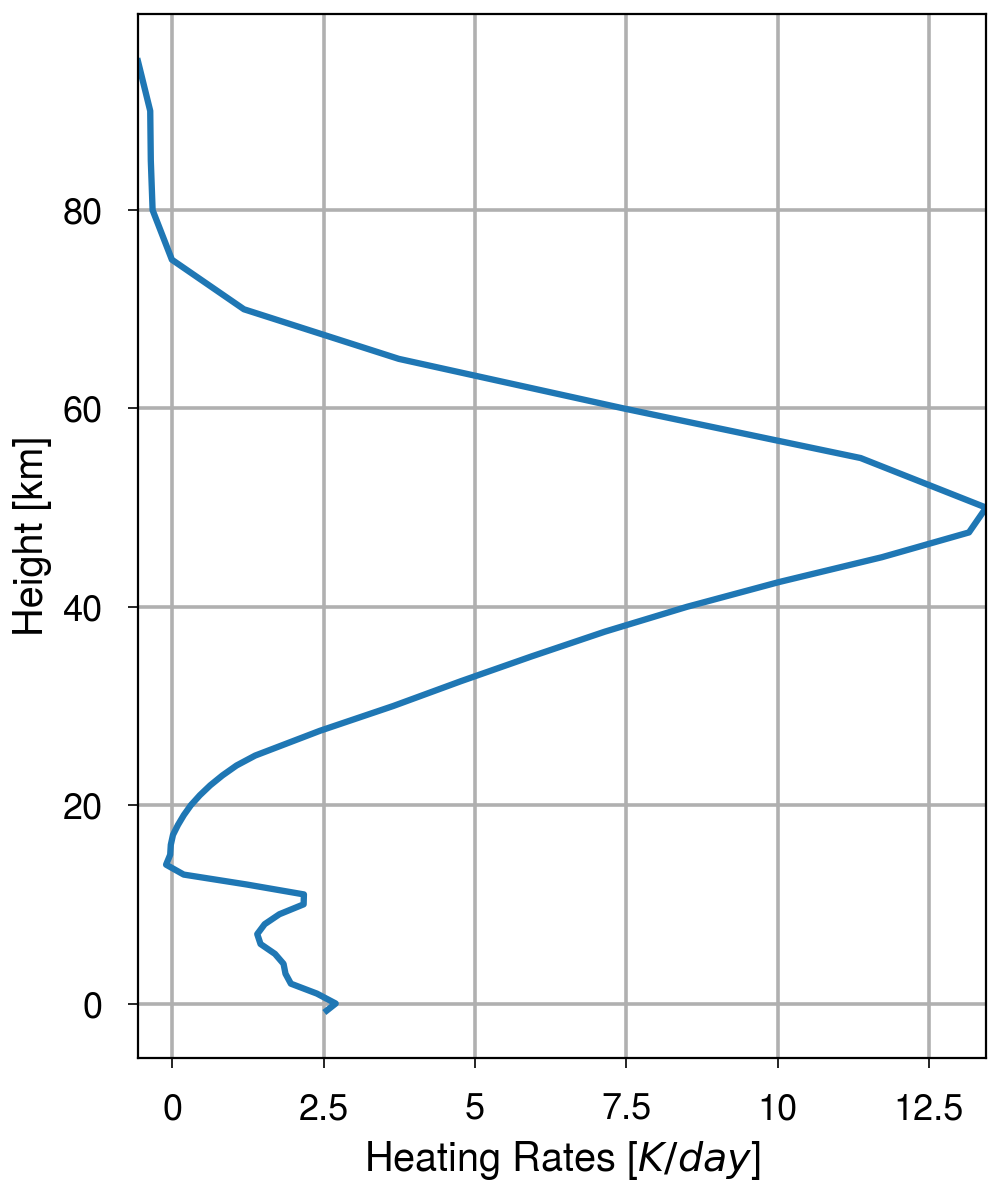

In [6]:
# Calculate heating rate and plot it
net_flux = flux_upward - flux_downward
HR,zp_lay = calc_heatingrates(z, p, T, net_flux)
fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(5,6))
axs.plot(HR.squeeze()* 3600*24, z/1000.)
axs.format(grid=True, ylabel="Height [km]", xlabel="Heating Rates [$K/day$]")
pplt.show()

### 3)
Calculate the spectral upward, downward and net flux using the function `calc_spectral_irradiance`.

In [7]:
# Calculate the spectral irradiance (spectral flux)

f, z, p, T, spectral_flux_downward, spectral_flux_upward = calc_spectral_irradiance( atmfield, fnum=1_000, nstreams=2, verbosity=1)
spectral_flux_downward = spectral_flux_downward*(3e8) # convert from W/(m2 Hz) to W/(m2 * m-1)
spectral_flux_upward = spectral_flux_upward*(3e8) # convert from W/(m2 Hz) to W/(m2 * m-1)


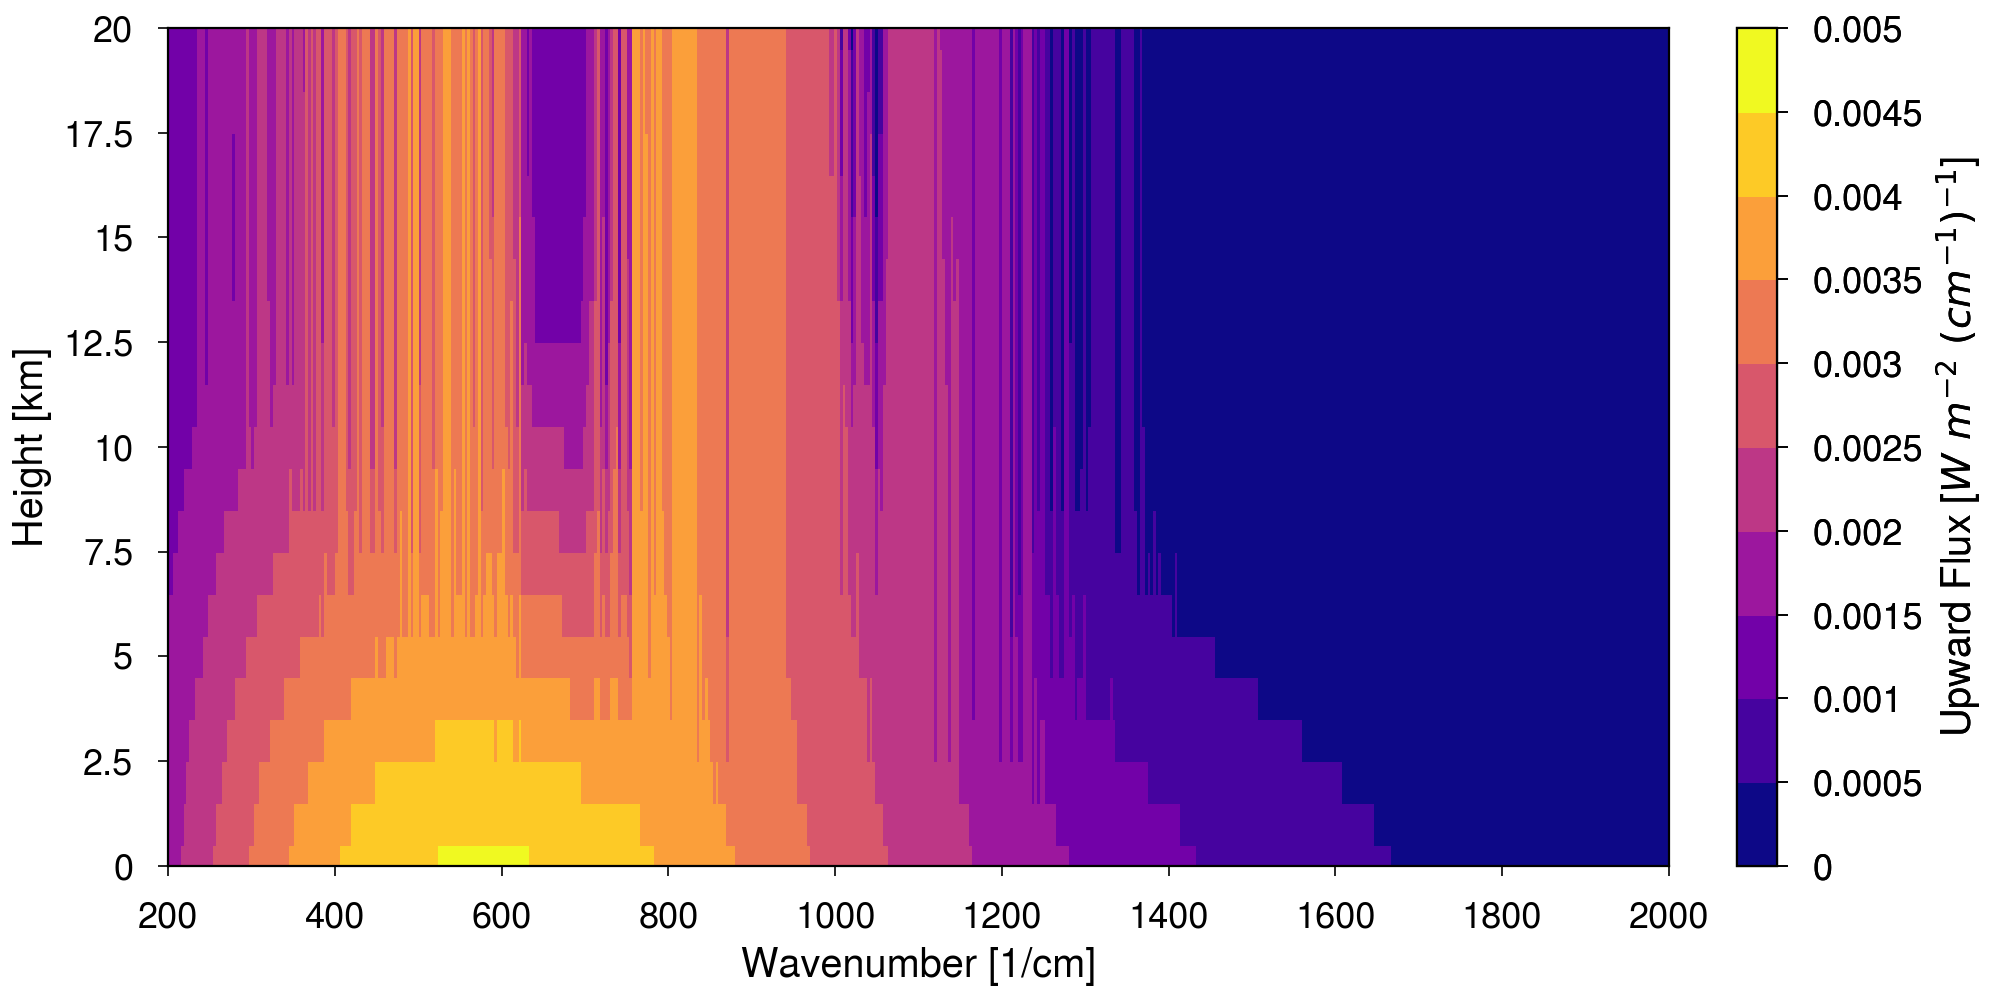

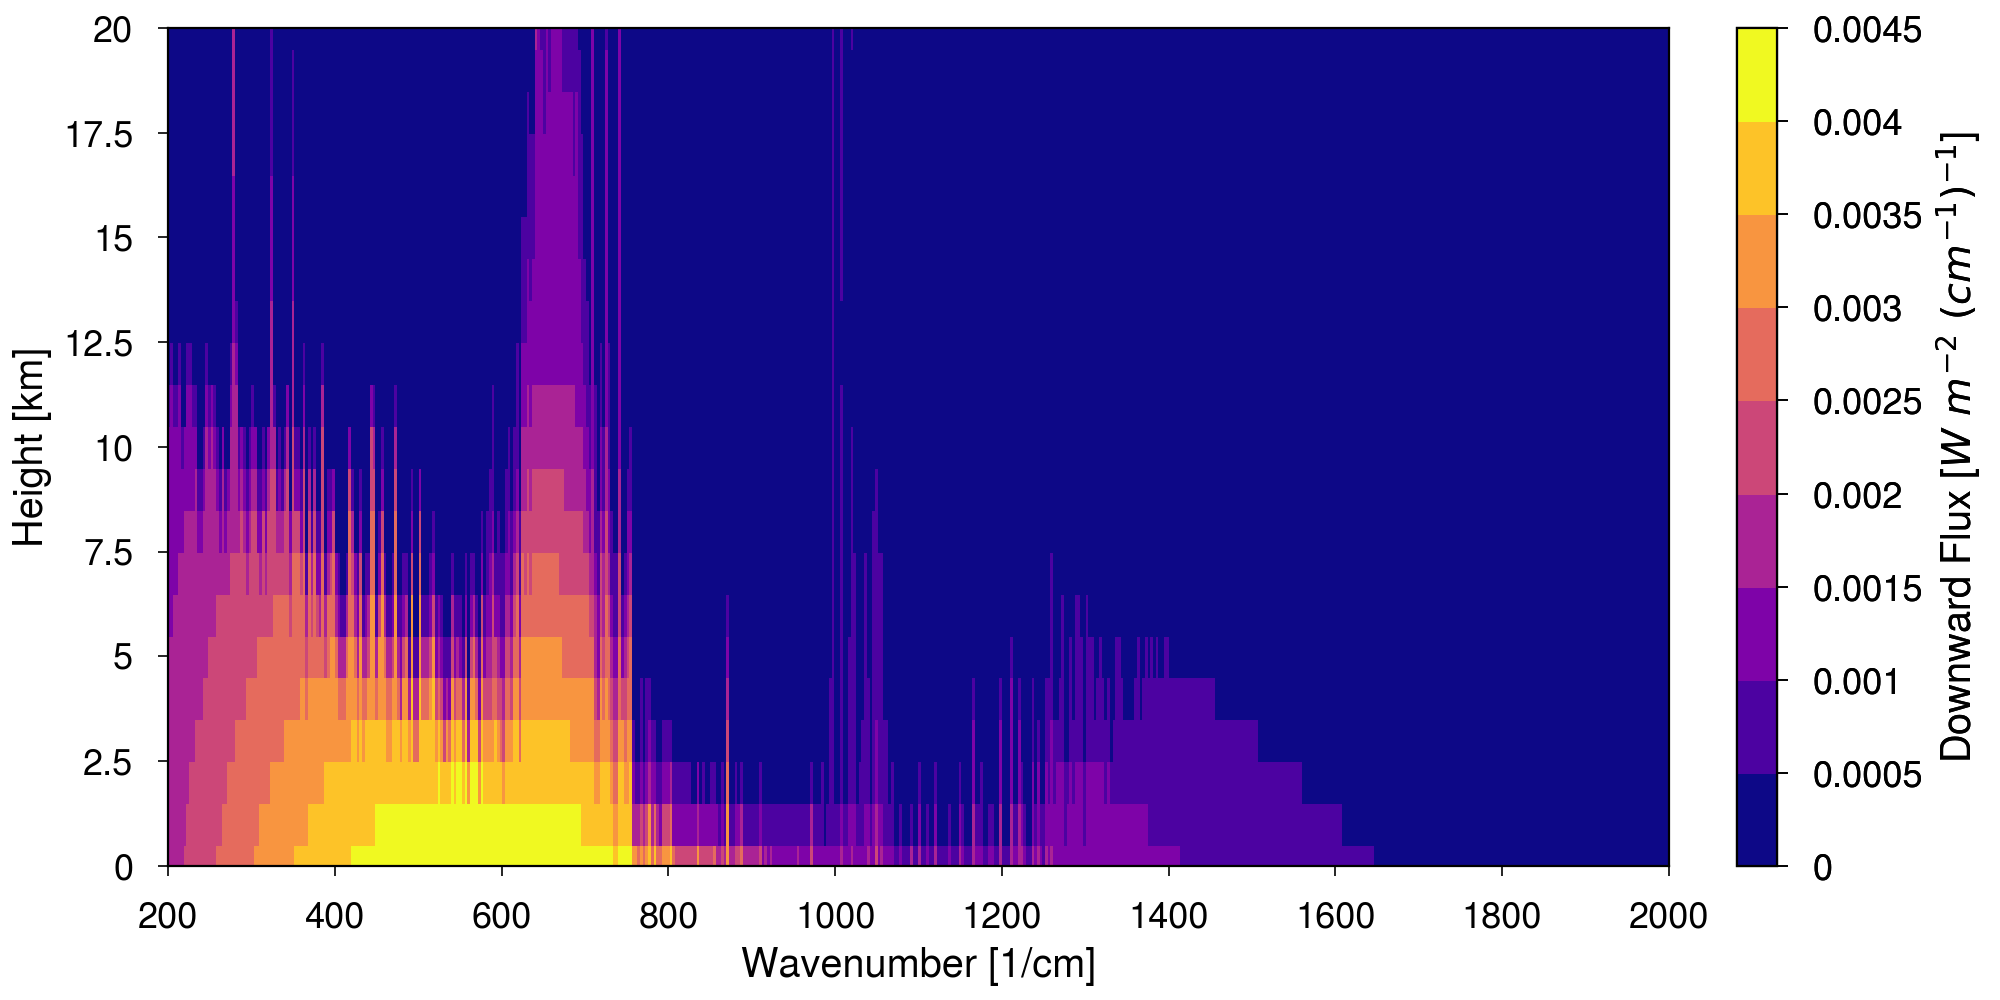

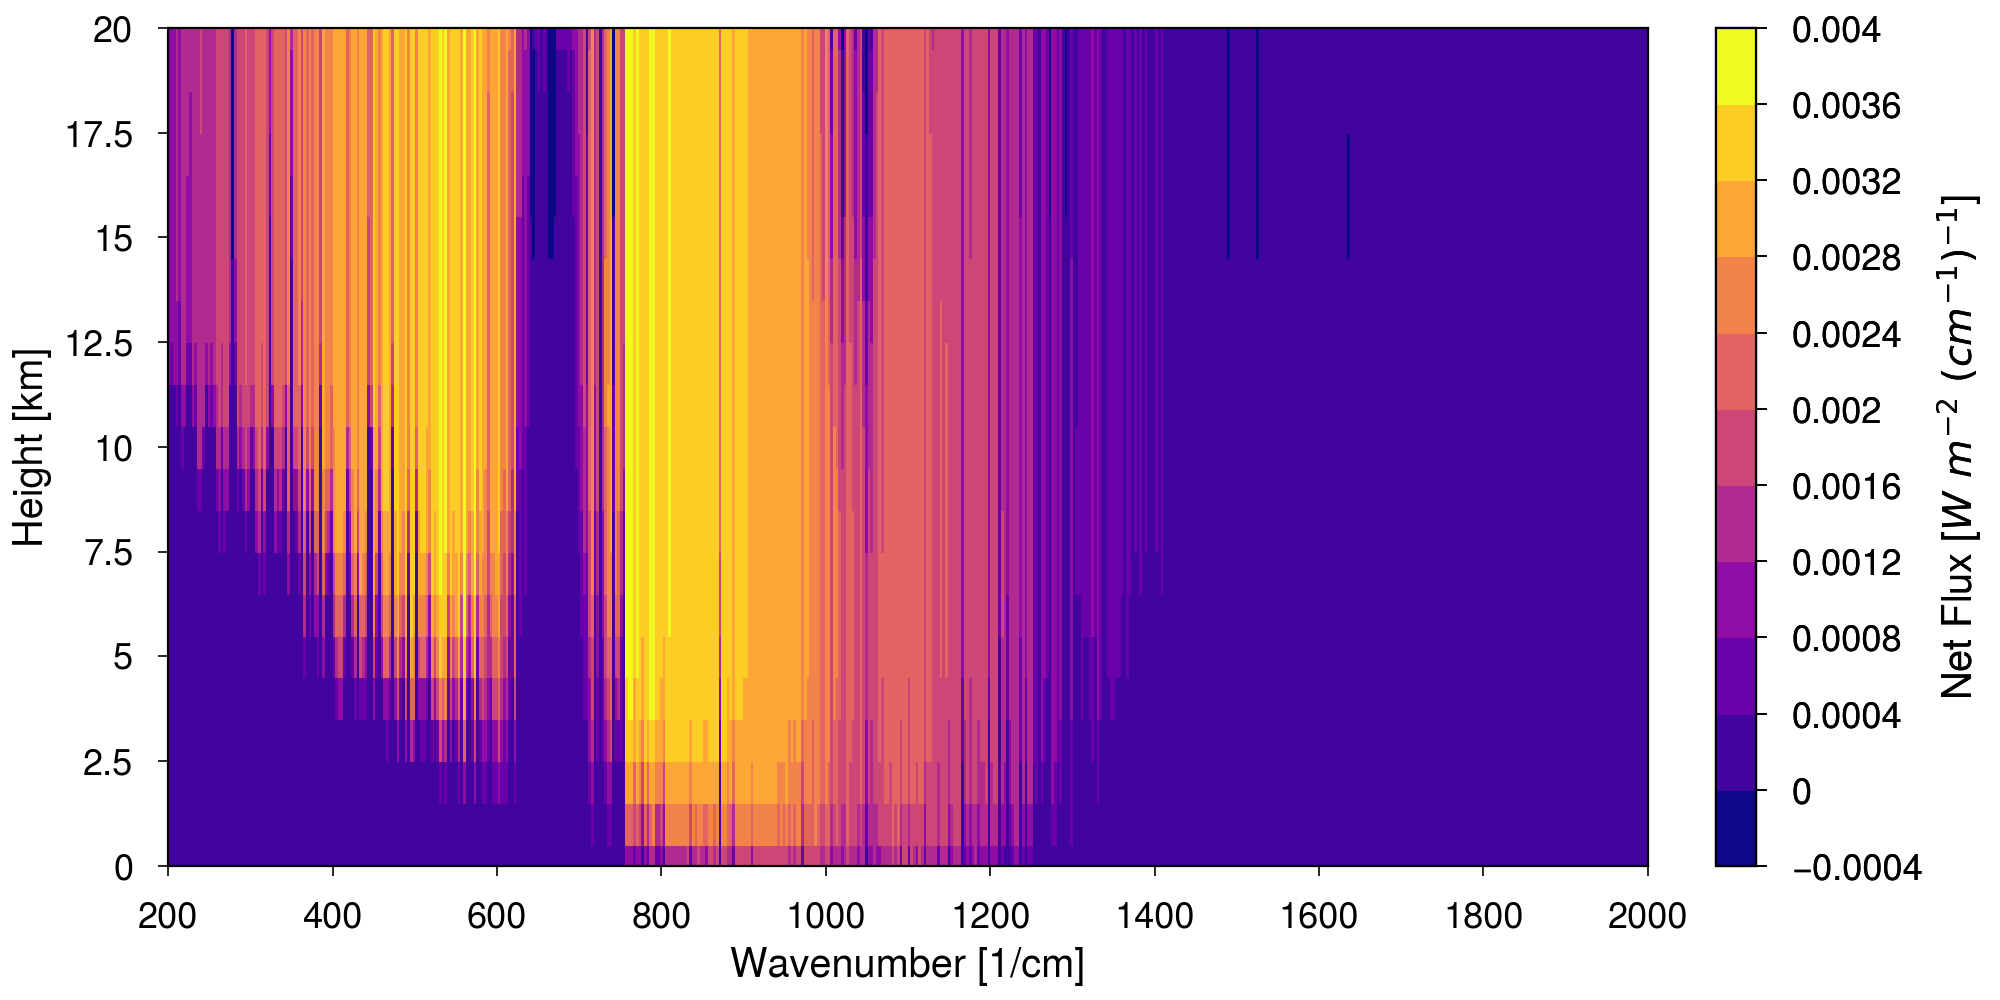

In [8]:
funit = f * ureg.Hz
wnum = funit.to('1/cm', 'spectroscopy')

fig, ax = pplt.subplots(ncols=1, nrows=1, figsize=(10,5))
fig.format(xlim=(3,20), ylim=(0,20), ylabel="Height [km]", xlabel="Wavelength [µm]")
fig.format(xlim=(200,2000), ylim=(0,20), ylabel="Height [km]", xlabel="Wavenumber [1/cm]")

c = ax.pcolormesh(wnum.magnitude, z/1000., (spectral_flux_upward).T, cmap='plasma')
#cb = fig.colorbar(c, label='Net Flux [$W\ m^{-2}\ m^{-1}$]')
cb = fig.colorbar(c, label=r'Upward Flux [$W\ m^{-2}\ (cm^{-1})^{-1}$]')

pplt.show()


fig, ax = pplt.subplots(ncols=1, nrows=1, figsize=(10,5))
fig.format(xlim=(3,20), ylim=(0,20), ylabel="Height [km]", xlabel="Wavelength [µm]")
fig.format(xlim=(200,2000), ylim=(0,20), ylabel="Height [km]", xlabel="Wavenumber [1/cm]")

c = ax.pcolormesh(wnum.magnitude, z/1000., (spectral_flux_downward).T, cmap='plasma')
#cb = fig.colorbar(c, label='Net Flux [$W\ m^{-2}\ m^{-1}$]')
cb = fig.colorbar(c, label='Downward Flux [$W\ m^{-2}\ (cm^{-1})^{-1}$]')

pplt.show()


fig, ax = pplt.subplots(ncols=1, nrows=1, figsize=(10,5))
fig.format(xlim=(3,20), ylim=(0,20), ylabel="Height [km]", xlabel="Wavelength [µm]")
fig.format(xlim=(200,2000), ylim=(0,20), ylabel="Height [km]", xlabel="Wavenumber [1/cm]")

c = ax.pcolormesh(wnum.magnitude, z/1000., (spectral_flux_upward - spectral_flux_downward).T, cmap='plasma')
#cb = fig.colorbar(c, label='Net Flux [$W\ m^{-2}\ m^{-1}$]')
cb = fig.colorbar(c, label='Net Flux [$W\ m^{-2}\ (cm^{-1})^{-1}$]')

pplt.show()

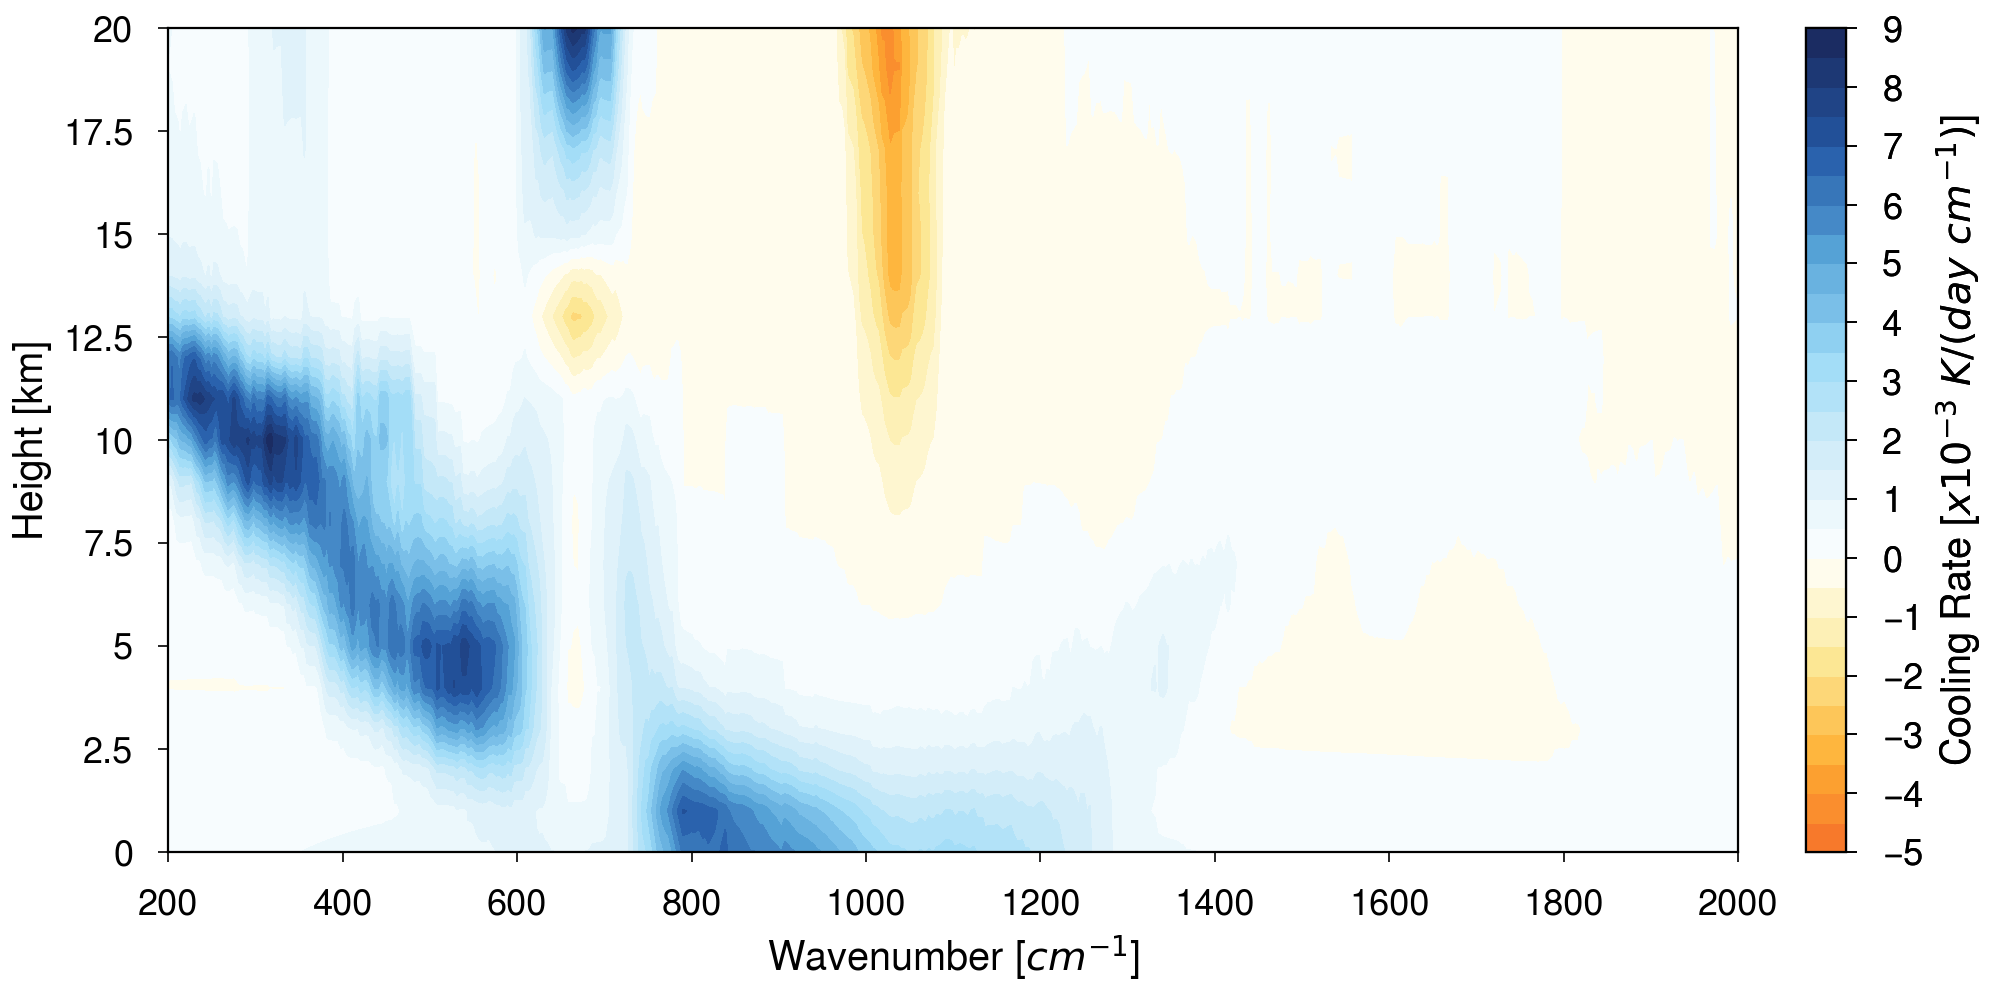

In [9]:
net_flux = (spectral_flux_upward - spectral_flux_downward).T
HR,zp_lay = calc_heatingrates(z, p, T, net_flux)

# Smooth the spectral heating rates
smoothed_HR = np.ones(HR.shape)
for i, layer in enumerate(HR):
    N = 20
    smoothed_HR[i,:] = np.convolve(layer, np.ones(N)/N, mode='same')

fig, ax = pplt.subplots(ncols=1, nrows=1, figsize=(10,5))
fig.format(xlim=(200,2000), ylim=(0,20), ylabel="Height [km]", xlabel="Wavenumber [$cm^{-1}$]")

levels = 30
c= ax.contourf(wnum.magnitude, z/1000., smoothed_HR* 3600.*24.*100.*1e3, levels=levels, cmap="ColdHot_r")
cb = fig.colorbar(c, label='Cooling Rate [$x10^{-3}\ K/(day\ cm^{-1})$]')

pplt.show()

### 4)
Use the function `integrate_spectral_irradiance(...)` to integrate  
the spectral irradiance over three continuing bands:

* the far infrared
* the $\text{CO}_2$-band
* the window-region and above.

Calculate the heating rate for each band and plot them together with the total  
heating rate from Task 2. Compare the band heating rates with the total  
heating rate and explain differences.

In [16]:
# calculate the heating rate for each band and plot them together with the other heating rate
net_flux = (spectral_flux_upward - spectral_flux_downward)
flux_band = integrate_spectral_irradiance(wnum.magnitude, net_flux)
heating, z = calc_heatingrates(z, p, T, flux_band)

In [17]:
heating

array([ 3.07793894e-07,  3.24587014e-07,  2.78934477e-07,  2.11364416e-07,
        1.92603381e-07,  2.03799921e-07,  2.17929607e-07,  2.08628762e-07,
        1.95792818e-07,  1.95329806e-07,  2.12742396e-07,  2.42912598e-07,
        2.34244903e-07,  1.34567986e-07,  2.58807665e-08, -2.47190661e-09,
        7.90649294e-09,  1.29606723e-08,  2.01647084e-08,  3.11150525e-08,
        4.30839577e-08,  5.61391335e-08,  6.99432921e-08,  8.23357721e-08,
        9.24643241e-08,  9.74592720e-08,  1.04555109e-07,  1.52857165e-07,
        2.26969156e-07,  3.20985689e-07,  4.33406352e-07,  5.60114272e-07,
        7.64157539e-07,  1.13378258e-06,  1.65461192e-06,  2.13167665e-06,
        2.28744288e-06,  1.89762289e-06,  1.10596432e-06,  4.26483247e-07,
        2.90322284e-08, -1.10985065e-07, -1.22231603e-07, -1.12615819e-07,
       -1.15855038e-07, -1.82468930e-07])